# Scratch for getting SRILM to work through a jupyter notebook
Using these resources for SRILM: https://okapiframework.org/wiki/index.php?title=SRILM_Installation_and_Running_Tutorial, http://www.cs.brandeis.edu/~cs114/CS114_docs/SRILM_Tutorial_20080512.pdf, 
http://www.speech.sri.com/projects/srilm/manpages/ngram-count.1.html

In [104]:
import sys
import os
import csv as csv
import pandas as pd
from nltk.tokenize import word_tokenize
import math
import time


# get some useful paths
SRILM_BIN_PATH = '../../../tools/SRILM/bin/i686-m64/'
CORPUS_PATH = '../data/srilm_data/'
LM_OUTPUT_PATH = '../srilms_LMs/'

%run -n lib/SLM_building.py
os.getcwd()
# MONTHS = [str(m) for m in range(1,13)]



'/homes/gws/taugust/ARK/community_guidelines'

In [105]:
os.chdir('/homes/gws/taugust/ARK/community_guidelines/')


# Functions very similar to what is in SLM building but adds in SRILM


In [106]:
# %%writefile ../lib/SRILM_building.py 

# FUNCTIONS FOR SRILM BUILDING

def export_text(text, name, corpus_path='../data/srilm_data/'):
    pd.Series(text).to_csv(corpus_path + name + '.txt', sep='\n', index=False, quoting=csv.QUOTE_NONE)
    return corpus_path + name + '.txt'
    
# def clean_and_export(df, name, text_col='body'):
#     df = df.dropna(subset=[text_col])
#     df[text_col]= df[text_col].apply(lambda x: x.replace('\n', ' '))
#     df[text_col] = df[text_col].apply(lambda x: ' '.join([w.lower() for w in word_tokenize(x)][:10]))
#     df[text_col].to_csv(CORPUS_PATH + name, sep='\n', index=False, quoting=csv.QUOTE_NONE)
#     return CORPUS_PATH + name
    
def train_SRILM(ngram_count_command, corpus, count_file, lm):
    print('Reading text corpus at', colored(corpus, 'green'), ' and writing to count file ', colored(count_file, 'magenta'), '.....', end='')
    ! {ngram_count_command} -text {corpus} -order 2 -write {count_file} -unk 
    print('Done')
    print('Training LM from count file', colored(count_file, 'magenta'), ' to ', colored(lm, 'red'), '....', end='')
    ! {ngram_count_command} -read {count_file} -order 2 -lm {lm} -gt1min 3 -gt1max 7 -gt2min 3 -gt2max 7
    print('Done')
    
# Calculate entropy for SRILM LM path
# requrires Jupyter magic
def get_SRILM_entropy(ngram_command, lm_path, test_text_path):
    ppl_output = ! {ngram_command} -ppl {test_text_path} -lm {lm}
    ppl = float(ppl_output[1].split(' ')[5])
    return math.log(ppl,2)

def construct_LM_SRILM(active_user_text, sub_name, month, index_num, vocab=None, ngram_count_command='./../../tools/SRILM/bin/i686-m64/ngram-count'):
    corpus_path = export_text(active_user_text, name=sub_name+'_'+str(index_num)+'_month_'+str(month))
    
    count_file = '../srilms_LMs/counts/' + kind + '/' + sub_name +'_'+str(index_num)+'_month_'+str(month)+'.count'
    lm_path = '../srilms_LMs/' + kind + '/' + sub_name + '/' +sub_name+'_'+str(index_num)+'_month_'+str(month)+'.lm'
    
    train_SRILM(ngram_count_command, corpus_path, count_file, lm_path)
    return lm_path


# build an SLMs for a single month
def build_SLMs_SRILM(df, author_counts, slm_count, month, name, kind=None):
    print('Creating ', colored(str(slm_count) + ' SLMs ', 'red'), 'for', colored(' month ' + str(month), 'green'), '.....')
    slms = []
    for i in range(0, slm_count):
        active_users = get_active_users(author_counts, str(month), 'author', kind=kind)
        print(month)
        active_user_comments = get_user_comments(df, list(active_users), month=month, num_posts=5)
        slm_path = construct_LM_SRILM(active_user_comments, name, month, i)
        slms.append(slm_path)
    return slms

# returns dict of {month:SLM}
def build_monthly_SLM_SRILM(df, author_counts, slm_count, name, use_saved_lms=False, kind=None):
    slm_dict = {}
    # if we don't want to remake the LMs, can just load our old ones
    if use_saved_lms:
        for m in MONTHS:
            slms = []
            for i in range(0, slm_count):
                slms.append('../srilms_LMs/'+ kind + '/' + name + '/' + name +'_'+str(i)+'_month_'+str(m)+'.lm')
            slm_dict[m] = slms
        return slm_dict
    # otherwise just remake them
    else: 
        for m in MONTHS:
            slms = build_SLMs_SRILM(df, author_counts, slm_count, month=m, name=name, kind=kind)
            slm_dict[m] = slms
        return slm_dict
    
def calc_month_entropy_SRILM(slms, text_path):
    entropies = []
    for i, slm in enumerate(slms):
        entropies.append(get_SRILM_entropy('./../../tools/SRILM/bin/i686-m64/ngram', slm, text_path))
    return entropies
    
def calc_acc_gap_SRILM(slms, author_counts, comments, sub_name, kind=None):
    monthly_acc_gap = {}
    for month in slms.keys():
        print('Calculating cross entropy for', colored('month ' + str(month), 'green'), '.....')
        active_authors = get_active_users(author_counts, str(month), 'author', threshold=10, num_authors=5, kind=kind)
        outside_authors = get_outside_users(author_counts, str(month), 'author', threshold=1, num_authors=50, kind=kind)
        print('sampled active users:', len(active_authors), 'sampled outside users:', len(outside_authors))

        active_comments = get_user_comments(comments, list(active_authors), month=month, num_posts=10)
        outside_comments = get_user_comments(comments, list(outside_authors), month=month, num_posts=1)
        print('sampled active comments:', len(active_comments), 'sampled outside comments:', len(outside_comments))
        
        # export to SRILM test directory
        active_corpus_file = export_text(active_comments, name=sub_name+'_inside_month_'+str(month), corpus_path='../data/srilm_data/test')
        outside_corpus_file = export_text(outside_comments, name=sub_name+'_outside_month_'+str(month), corpus_path='../data/srilm_data/test')
        
        # run through SRILM LMs for the month and get the entropy
        active_ent = calc_month_entropy_SRILM(slms[month], active_corpus_file)
        outside_ent = calc_month_entropy_SRILM(slms[month], outside_corpus_file)
        
        print(active_ent, outside_ent)
                
        # calculate the acc gap
        exp_val_active_ent = np.mean(active_ent)
        exp_val_outside_ent = np.mean(outside_ent)
                
        acc_gap_month = (exp_val_outside_ent - exp_val_active_ent) / exp_val_active_ent
        
        # also save variance of the acc gap by subtracting: https://www.kean.edu/~fosborne/bstat/05b2means.html
        var_active_ent = np.var(active_ent)
        var_outside_ent = np.var(outside_ent)
        
        acc_gap_var = (var_active_ent/len(active_ent)) + (var_outside_ent/len(outside_ent))
        
        monthly_acc_gap[month] = {}
        monthly_acc_gap[month]['gap'] = acc_gap_month
        monthly_acc_gap[month]['var'] = acc_gap_var
        print('Saving acc gap for', colored('month ' + str(month), 'green'))
    return monthly_acc_gap
       

# Comment-based SRILM SLM building 
Interested to see if post and comments are unique in different communities


In [113]:
%run -n lib/SLM_building.py


In [114]:
subs = ['science', 'politics', 'BabyBumps']
subs_acc = {}
for i, s in enumerate(subs):
    print('-----------------------------------------------')
    print('Acculturation Gap for ', colored(s, 'magenta'))
    print('-----------------------------------------------')

    # get author counts for both test and train sets
    # note that comments are the same for both, thats because the authors are all different, so we can pull comments 
    # from the same place
#     df_comments, df_author_counts_train = import_csvs(s, path='data/cleaned/train/2017/', ext='_train_2017.csv', comment_pre_path='data/cleaned/sub_comments/')
#     _, df_author_counts_test = import_csvs(s, path='data/cleaned/test/2017/', ext='_test_2017.csv', comment_pre_path='data/cleaned/sub_comments/')
    
    # build the SLMs using SRILM, this requires jupyter magic to run the bash commands for SRILM
    # Note that the paths can get weird here since SRILM + its data exists pretty far away from the notebooks
    # The SLMs are just saved in a directory: /homes/gws/taugust/ARK/srilms_LMs
    slms = build_monthly_SLM_SRILM(df_comments, df_author_counts_train, 1, name=s, use_saved_lms=False, kind='comment')
    
    # calculcate the acc gap using the saved SLMs
    monthly_acc_gaps = calc_acc_gap_SRILM(slms, df_author_counts_test, df_comments, s, kind='comment')
    
    subs_acc[s] = monthly_acc_gaps
    


-----------------------------------------------
Acculturation Gap for  science
-----------------------------------------------
Creating  1 SLMs  for  month 1 .....
comment


,Unnamed: 0,author,1,2,3,4,5,6,7,8,9,10,11,12,kind
74703,120,FireNexus,13.0,7.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,2.0,comment
34417,225,navinohradech,10.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,1.0,comment
30882,613,rydan,6.0,1.0,6.0,2.0,3.0,16.0,18.0,11.0,2.0,20.0,27.0,2.0,comment
19977,629,tigerhawkvok,6.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,comment
71458,447,surlyskin,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,comment
46129,46,TitaniumDragon,21.0,19.0,24.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,comment
3347,569,grndzro4645,6.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,3.0,12.0,2.0,comment
51327,207,ShockingBlue42,10.0,1.0,11.0,17.0,24.0,43.0,10.0,1.0,5.0,16.0,7.0,36.0,comment
41631,274,sl600rt,9.0,6.0,5.0,3.0,4.0,1.0,0.0,1.0,1.0,3.0,1.0,0.0,comment
67099,157,sailorbrendan,12.0,0.0,0.0,0.0,9.0,1.0,3.0,0.0,2.0,0.0,0.0,0.0,comment


1


,Unnamed: 0,kind,word_count,body,score_hidden,archived,name,author,author_flair_text,downs,...,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class,created_month
683,47606,comment,25.0,All of our consent forms assume that there is ...,NaN,NaN,NaN,50calPeephole,NaN,NaN,...,5.0,1488458268,0,0.0,dd6afk9,science,NaN,NaN,NaN,1.0
687,47637,comment,48.0,This is fascinating! I wonder if blood flow to...,NaN,NaN,NaN,Happy_Go_Lurky,NaN,NaN,...,8.0,1488459469,0,0.0,dd6cpnb,science,NaN,NaN,NaN,1.0
1043,72251,comment,212.0,Agreed. What she did was top notch hard word w...,NaN,NaN,NaN,MeloYelo,NaN,NaN,...,1.0,1488457867,0,0.0,dd69o66,science,NaN,NaN,NaN,1.0
1501,91377,comment,34.0,The interesting point was the suggested mechan...,NaN,NaN,NaN,DoloresColon,NaN,NaN,...,1.0,1488461216,0,0.0,dd6fyuh,science,NaN,NaN,NaN,1.0
1969,140115,comment,29.0,"Please explain to me like i'm five, how we ""kn...",NaN,NaN,NaN,RuffRalph,NaN,NaN,...,2.0,1488462518,0,0.0,dd6id51,science,NaN,NaN,NaN,1.0
2036,142185,comment,22.0,"To be fair, that scene in Kill bill was a Male...",NaN,NaN,NaN,Wolfencreek,NaN,NaN,...,2.0,1488455626,0,0.0,dd65dy8,science,NaN,NaN,NaN,1.0
2090,144239,comment,67.0,While I do admit in hindsight my title was a b...,NaN,NaN,NaN,leposava,NaN,NaN,...,1.0,1488463246,0,0.0,dd6jost,science,NaN,NaN,NaN,1.0
2206,152234,comment,19.0,They are the sweat shop workers of your body.....,NaN,NaN,NaN,Milkslinger,NaN,NaN,...,3.0,1488454955,0,0.0,dd643gj,science,NaN,NaN,NaN,1.0
2231,154116,comment,47.0,"so if the basal cells do not repair period, th...",NaN,NaN,NaN,Whiterabbit--,NaN,NaN,...,1.0,1488457057,0,0.0,dd685hs,science,NaN,NaN,NaN,1.0
3127,247196,comment,78.0,"I think you mean [*siderophile* elements, mean...",NaN,NaN,NaN,00fruit,NaN,NaN,...,2.0,1488462748,0,0.0,dd6irpw,science,NaN,NaN,NaN,1.0


-SpaceCommunist- 19
7LeagueBoots 13
ABabyAteMyDingo 6
AHucs 5
AReditAccount 11
Abedeus 6
Agent31984 5
AgoristWisconsin 6
Aoloach 11
AppleWedge 11
Arollok 9
BJPenwhistle 7
BabyThatsMyJam 6
Baron-of-bad-news 8
Biomirth 8
Black_RL 7
BogusProfiterole 7
Bokbreath 4


ValueError: Cannot take a larger sample than population when 'replace=False'

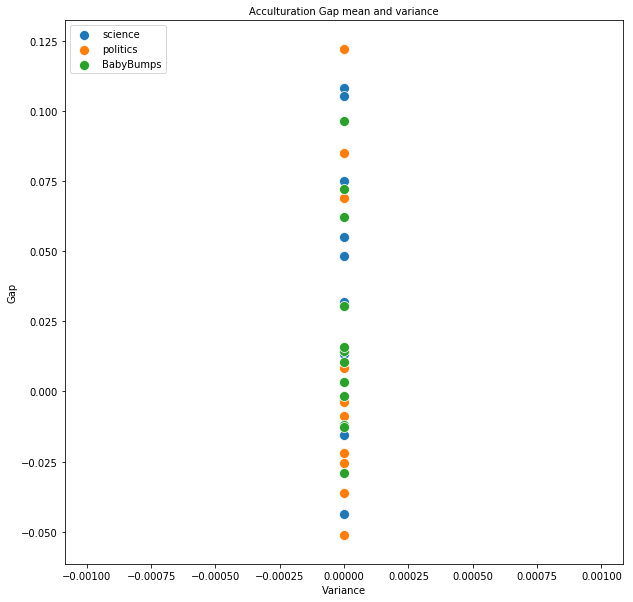

In [226]:

plt.figure(figsize=(10,10))

subs = {}
for sub in subs_acc.keys():
    subs[sub] = {}
    gap = [subs_acc[sub][m]['gap'] for m in range(1,13)]
    var = [subs_acc[sub][m]['var'] for m in range(1,13)]
    subs[sub]['gap'] = gap
    subs[sub]['var'] = var
    subs[sub]['mean_gap'] = np.mean(gap)
    ax = sns.scatterplot(x=subs[sub]['var'], y=subs[sub]['gap'], s=100 )
    
ax.set_title('Acculturation Gap mean and variance', fontsize=10)
ax.set_xlabel('Variance', fontsize=10)
ax.set_ylabel('Gap')
ax.legend(subs_acc.keys(), loc='upper left')

In [227]:
subs

{'science': {'gap': [-0.04352218675728774,
   0.05489978429891563,
   0.10808891738671997,
   0.07492695069946863,
   0.030573488059684063,
   0.048283024630856826,
   0.10509537017010052,
   0.013301540952192244,
   -0.003015126948600949,
   -0.015523094972229654,
   0.03127207816124475,
   0.03190400030158269],
  'var': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'mean_gap': 0.03635706216522058},
 'politics': {'gap': [-0.0018720371951840601,
   -0.025318020934817737,
   -0.05102929998800984,
   0.0687788611667632,
   0.003314182757368254,
   0.0848716787511846,
   -0.008823777218031093,
   0.12188516519431075,
   -0.021931719254625347,
   -0.03610688339912145,
   0.008361107719470094,
   -0.0038921155619701248],
  'var': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'mean_gap': 0.011519761836444773},
 'BabyBumps': {'gap': [-0.029214127388199094,
   0.062063463098360784,
   -0.012048887414940665,
   0.030439373444973387,
   0.003422135418659926,
 

In [19]:
slms_subs = {}
slms_subs['science'] = build_monthly_SLM_SRILM(None, None, 10, name='science', use_saved_lms=True)
slms_subs['politics'] = build_monthly_SLM_SRILM(None, None, 10, name='politics', use_saved_lms=True)

In [20]:
slms_subs

{'science': {'1': ['../srilms_LMs/science/science_0_month_1.lm',
   '../srilms_LMs/science/science_1_month_1.lm',
   '../srilms_LMs/science/science_2_month_1.lm',
   '../srilms_LMs/science/science_3_month_1.lm',
   '../srilms_LMs/science/science_4_month_1.lm',
   '../srilms_LMs/science/science_5_month_1.lm',
   '../srilms_LMs/science/science_6_month_1.lm',
   '../srilms_LMs/science/science_7_month_1.lm',
   '../srilms_LMs/science/science_8_month_1.lm',
   '../srilms_LMs/science/science_9_month_1.lm'],
  '2': ['../srilms_LMs/science/science_0_month_2.lm',
   '../srilms_LMs/science/science_1_month_2.lm',
   '../srilms_LMs/science/science_2_month_2.lm',
   '../srilms_LMs/science/science_3_month_2.lm',
   '../srilms_LMs/science/science_4_month_2.lm',
   '../srilms_LMs/science/science_5_month_2.lm',
   '../srilms_LMs/science/science_6_month_2.lm',
   '../srilms_LMs/science/science_7_month_2.lm',
   '../srilms_LMs/science/science_8_month_2.lm',
   '../srilms_LMs/science/science_9_month_2.lm'

In [222]:
{k:subs_acc[k]['gap'] for k in subs_acc.keys()}

KeyError: 'gap'

# Post-based SRILM SLM building 
Interested to see if post and comments are unique in different communities


In [ ]:
subs = ['science']
subs_acc = {}
for i, s in enumerate(subs):
    print('-----------------------------------------------')
    print('Acculturation Gap for ', colored(s, 'magenta'))
    print('-----------------------------------------------')

    # get author counts for both test and train sets
    # note that posts are the same for both, thats because the authors are all different, so we can pull posts 
    # from the same place
    df_posts, df_author_counts_train = import_csvs(s, path='data/cleaned/train/2017/', ext='_train_2017.csv', comment_pre_path='data/cleaned/sub_comments/')
    _, df_author_counts_test = import_csvs(s, path='data/cleaned/test/2017/', ext='_test_2017.csv', comment_pre_path='data/cleaned/sub_comments/')
    
    # build the SLMs using SRILM, this requires jupyter magic to run the bash commands for SRILM
    # Note that the paths can get weird here since SRILM + its data exists pretty far away from the notebooks
    # The SLMs are just saved in a directory: /homes/gws/taugust/ARK/srilms_LMs
    slms = build_monthly_SLM_SRILM(df_comments, df_author_counts_train, 10, name=s, use_saved_lms=False)
    
    # calculcate the acc gap using the saved SLMs
    monthly_acc_gaps = calc_acc_gap_SRILM(slms, df_author_counts_test, df_comments, s)
    
    subs_acc[s] = monthly_acc_gaps